# Imputation methods for in-hospital mortality prediction

In [9]:
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sn
from sklearn import metrics

### Extract the variables and count the missing data

In [10]:
# Read in the data and only select the continuous variables:
config = json.load(open('../resources/discretizer_config.json', 'r'))
is_categorical = config['is_categorical_channel']
categorical_var = [key for key, value in config['is_categorical_channel'].items() if value][1:]
patient_identifiers = ['icustay_id', 'subject_id', 'hadm_id', 'hours_in']
data = pd.read_csv('E:/MIMIC-III-ML/Preprocessing/notebooks/mimic_timeseries_data_not_imputed.csv')

# Filter out subjects with length of stay < 48 hours for the in-hospital mortality task:
y = pd.read_hdf('E:/MIMIC-III-ML/Preprocessing/notebooks/vitals_hourly_data_preprocessed.h5', 'Y')['los']
indices_to_remove = []
for i, row in y.iteritems():
    if row < 48:
        indices_to_remove.append(i)
        
data = data.reset_index().set_index('icustay_id').drop(indices_to_remove, axis = 0)
y = y.drop(indices_to_remove, axis = 0)

# Extract only the first 48 hours:
data = data[data['hours_in'] < 48].reset_index().set_index(['icustay_id', 'subject_id', 'hadm_id', 'hours_in']).drop('index', axis = 1)

In [11]:
print('Number of samples: ', data.shape[0])
print('Number of ICU stays: ', len(data.groupby('icustay_id')))

non_nans_per_predictor = np.array(list(data.groupby('icustay_id').apply(lambda x: np.count_nonzero(~np.isnan(x.values[:, 4:]), 
                                                                                           axis = 0))))
total_missing_predictors = 0
for subject in non_nans_per_predictor:
    for predictor in subject:
        if predictor == 0:
            total_missing_predictors += 1
print('Total number of predictors that are missing at every hour (per subject): ', total_missing_predictors)

Number of samples:  843312
Number of ICU stays:  17569
Total number of predictors that are missing at every hour (per subject):  29010


In [13]:
data

Diastolic blood pressure  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                        49.000000   
                              1                        52.000000   
                              2                        52.333333   
                              3                        60.500000   
                              4                        61.000000   
...                                                          ...   
299995     28775      134959  43                       82.000000   
                              44                             NaN   
                              45                             NaN   
                              46                       65.000000   
                              47                             NaN   

                                        Fraction inspired oxygen  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                              NaN   
                              1                              NaN   
                              2                              NaN   
                              3                              NaN   
                              4                              NaN   
...                                                          ...   
299995     28775      134959  43                             NaN   
                              44                             NaN   
                              45                             NaN   
                              46                             NaN   
                              47                             NaN   

                                        Glascow coma scale eye opening  \
icustay_id subject_id hadm_id hours_in                                   
200003     27513      163557  0                                    4.0   
                              1                                    NaN   
                              2                                    NaN   
                              3                                    NaN   
                              4                                    NaN   
...                                                                ...   
299995     28775      134959  43                                   NaN   
                              44                                   NaN   
                              45                                   NaN   
                              46                                   4.0   
                              47                                   NaN   

                                        Glascow coma scale motor response  \
icustay_id subject_id hadm_id hours_in                                      
200003     27513      163557  0                                       6.0   
                              1                                       NaN   
                              2                                       NaN   
                              3                                       NaN   
                              4                                       NaN   
...                                                                   ...   
299995     28775      134959  43                                      NaN   
                              44                                      NaN   
                              45                                      NaN   
                              46                                      6.0   
                              47                                      NaN   

                                        Glascow coma scale total  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                             15.0   
                              1                              NaN   
                              2  

### Imputation of all predictors

In [12]:
# Initialize matrix to store the results of different imputation methods:
data = data.drop('Unnamed: 0', axis = 1)
original_data = pd.DataFrame(index = data.index, columns = data.columns)
results_mean_imp = pd.DataFrame(index = data.index, columns = data.columns)
results_joint_imp = pd.DataFrame(index = data.index, columns = data.columns)

AttributeError: type object 'object' has no attribute 'dtype'

In [ ]:
counter = 0
n_folds = 100
unique_icustays = np.unique(data.index.get_level_values('icustay_id'))
kf = KFold(n_splits=n_folds, random_state=0, shuffle=True)
for train_index, test_index in kf.split(unique_icustays):
    
    print('Imputing fold ', counter + 1, '/', n_folds, end = '\r')
    counter += 1
    
    train_index = unique_icustays[train_index]
    test_index = unique_icustays[test_index]
    
    data_train = data.iloc[data.index.get_level_values('icustay_id').isin(train_index)]
    data_test = data.iloc[data.index.get_level_values('icustay_id').isin(test_index)]
    for i in range(len(data.columns)): # round categorical to closest category
        if data.columns[i] in categorical_var:
            data_test.loc[:, data.columns[i]] = np.round(data_test.loc[:, data.columns[i]])
    original_data.loc[data.index.get_level_values('icustay_id').isin(test_index), :] = data_test
    
    # Replace the test data with NaNs so we can learn the values:
    data_test = np.empty(data_test.shape)
    data_test[:] = np.nan
    
    # Mean imputation:
    mean_imp = np.nanmean(data_train, axis = 0)
    for i in range(len(mean_imp)): # round categorical to closest category
        if data.columns[i] in categorical_var:
            mean_imp[i] = np.round(mean_imp[i])  
    results_mean_imp.loc[data.index.get_level_values('icustay_id').isin(test_index), :] = mean_imp
    
    # Joint imputation: first extract the mu and covariance, then sample from the Gaussian distribution:    
    mu = np.nanmean(data_train.values, axis = 0)
    data_train_no_nans = data_train.values
    for i in range(data_train.values.shape[1]):
        data_train_no_nans[:, i] = np.nan_to_num(data_train.values[:, i], nan = mu[i])
    data_train_no_nans = data_train_no_nans.T
    sigma = np.cov(data_train_no_nans)
    sample = np.random.multivariate_normal(mu, sigma, size = len(unique_icustays))
    sample = np.mean(sample, axis = 0)
    for i in range(len(sample)): # round categorical to closest category
        if data.columns[i] in categorical_var:
            sample[i] = np.round(sample[i])
    results_joint_imp.loc[data.index.get_level_values('icustay_id').isin(test_index), :] = sample

In [ ]:
# Evaluate the performances of the two imputation methods: When using 100 folds and 17569 samples
rmse_meanimp = np.mean(np.sqrt(np.mean((results_mean_imp - original_data)**2)))
rmse_jointimp = np.mean(np.sqrt(np.mean((results_joint_imp - original_data)**2)))
print('Root mean-squared error mean imputation:', rmse_meanimp)
print('Root mean-squared error joint imputation:', rmse_jointimp)

Root mean-squared error mean imputation: 11.492452443679586
Root mean-squared error joint imputation: 11.49255445080119


In [ ]:
# Using 100 folds and 17569 samples:
rmse_per_predictor_mean = np.sqrt(np.mean((results_mean_imp - original_data)**2))
rmse_per_predictor_jointimp = np.sqrt(np.mean((results_joint_imp - original_data)**2))
print('RMSE per predictor:')
print('Mean\tJoint\tPredictor\n')
for i in range(len(rmse_per_predictor_mean)):
    print(str(round(rmse_per_predictor_mean[i], 2)) + '\t' + str(round(rmse_per_predictor_jointimp[i], 2)) +'\t' + results_mean_imp.columns[i])

RMSE per predictor:
Mean	Joint	Predictor

13.8	13.8	Diastolic blood pressure
0.19	0.19	Fraction inspired oxygen
1.12	1.12	Glascow coma scale eye opening
1.39	1.39	Glascow coma scale motor response
3.79	3.79	Glascow coma scale total
1.9	1.9	Glascow coma scale verbal response
58.52	58.52	Glucose
17.68	17.68	Heart Rate
12.76	12.76	Height
15.17	15.17	Mean blood pressure
3.49	3.49	Oxygen saturation
5.83	5.83	Respiratory rate
21.62	21.62	Systolic blood pressure
0.82	0.82	Temperature
25.72	25.72	Weight
0.08	0.08	pH


### In-hospital mortality prediction using joint modelling imputation vs. mean imputation

In [ ]:
# Only impute the NaNs in the original data:
imputed_data = original_data.fillna(results_joint_imp)
imputed_data.to_csv('imputed_in_hospital_mortality_data_no_ffill.csv')

In [ ]:
# Load newly imputed data, preprocessed data, and outcomes:
imputed_data = pd.read_csv('imputed_in_hospital_mortality_data_no_ffill.csv')
X = pd.read_hdf('../vitals_hourly_data_preprocessed.h5', 'X')
Y = pd.read_hdf('../vitals_hourly_data_preprocessed.h5', 'Y')
X = X.sort_index(axis = 0, level = 'icustay_id')
Y = Y.sort_index(axis = 0, level = 'icustay_id')

# Load the config file that contains information about continuous/categorical variables:
config = json.load(open('../resources/discretizer_config.json', 'r'))
categorical_var = [key for key, value in  config['is_categorical_channel'].items() if value][1:]
continuous_var = [key for key, value in  config['is_categorical_channel'].items() if not value]

In [ ]:
# Remove ICU stays that took less than 48 hours:
indices_to_remove = []
for i, row in Y.iterrows():
    if row['los'] < 48:
        indices_to_remove.append(i)
X = X.reset_index().set_index('icustay_id').drop(indices_to_remove, axis = 0)
Y = Y.drop(indices_to_remove, axis = 0)

# Extract only the first 48 hours:
X = X[X['hours_in'] < 48].reset_index().set_index(['icustay_id', 'subject_id', 'hadm_id', 'hours_in'])
imputed_data = imputed_data.set_index(['icustay_id', 'subject_id', 'hadm_id', 'hours_in'])

In [ ]:
# Minmax standardization of the continuous variables:
def minmax(x):
    mins = x.min()
    maxes = x.max()
    x_std = (x - mins) / (maxes - mins)
    return x_std

for column in imputed_data.columns:
    if column not in categorical_var:
        imputed_data.loc[:, column] = minmax(imputed_data.loc[:, column].values)

In [ ]:
# One-hot encoding:
categorical_data = imputed_data[categorical_var]
one_hot = pd.get_dummies(categorical_data, columns=categorical_var)
for c in categorical_var:
    if c in imputed_data.columns:
        imputed_data.drop(c, axis = 1, inplace=True)
imputed_data = pd.merge(imputed_data.reset_index(), one_hot.reset_index(), how='inner', left_on=['subject_id', 'icustay_id', 'hadm_id', 'hours_in'],
                           right_on=['subject_id', 'icustay_id', 'hadm_id', 'hours_in'])
imputed_data = imputed_data.set_index(['subject_id', 'icustay_id', 'hadm_id', 'hours_in'])

In [ ]:
# Combine X and the imputed data:
imputed_data.index = X.index
variables = imputed_data.columns
new_variables = {}
for v in imputed_data.columns:
    if v in continuous_var:
        new_variables[v] = v + '1'
imputed_data = imputed_data.rename(columns = new_variables)

for c in continuous_var:
    imputed_data[c] = X[c]
    imputed_data[c +'2'] = X[c + '2']

In [ ]:
imputed_data.to_hdf('inhospital_mortality_data_preprocessed_new_imputation.h5', 'X')
Y.to_hdf('inhospital_mortality_data_preprocessed_new_imputation.h5', 'Y')

In [ ]:
x = np.array(list(imputed_data.reset_index().groupby('icustay_id').apply(lambda x: x.values[:, 4:])))
x = np.reshape(x, (x.shape[0], -1)).astype('float32')
y = np.array(list(Y.groupby('icustay_id').apply(lambda i: i['in_hospital_mortality'].to_numpy())))[:, 0].astype('float32')

In [ ]:
def undersample_majority(x_train, y_train):
    
    # Separate the positive and negative x/y data:
    pos_features = x_train[y_train == 1]
    neg_features = x_train[y_train == 0]
    pos_labels = y_train[y_train == 1]
    neg_labels = y_train[y_train == 0]
    
    # Count the number of negative data points, and select that many from the positive data points. This means that 
    # positive samples will be 'copied' or repeated and hence occur multiple times in the training data:
    ids = np.arange(len(neg_features))
    choices = np.random.choice(ids, len(pos_features))
    res_neg_features = neg_features[choices]
    res_neg_labels = neg_labels[choices]
    
    # Combine the resamples and negative data points, and shuffle:
    resampled_features = np.concatenate([res_neg_features, pos_features], axis=0)
    resampled_labels = np.concatenate([res_neg_labels, pos_labels], axis=0)
    order = np.arange(len(resampled_labels))
    np.random.shuffle(order)
    resampled_features = resampled_features[order]
    resampled_labels = resampled_labels[order]
    return resampled_features, resampled_labels

In [ ]:
# Stratified 5-fold cross-validation:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
predictions_logreg_ae = []
y_true_logreg_ae = []
for train_index, test_index in kf.split(x, y):
    
    # Split in training and test set, and split the training further in training and validation sets 
    # (for a fair comparison with the autoencoder):
    x_train, x_val, y_train, y_val = train_test_split(x[train_index], y[train_index], test_size=0.125, random_state=0, 
                                            stratify=y[train_index])
    x_test, y_test = x[test_index], y[test_index]
    
    x_train, y_train = undersample_majority(x_train, y_train)
    
    # Initialize and fit a model:
    logreg = LogisticRegression(random_state = 0, C = 0.001)
    logreg.fit(x_train, y_train)
    
    # Make predictions:
    pred = logreg.predict_proba(x_test)
    predictions_logreg_ae.append(list(pred))
    y_true_logreg_ae.append(list(y_test))

In [ ]:
# Collect the results:
y_true_logreg_combined_ae = np.concatenate(y_true_logreg_ae)
predictions_logreg_combined_ae = np.concatenate(predictions_logreg_ae)

### In-hospital mortality prediction using the standard imputated method (from preprocessing notebook)

In [ ]:
x = np.array(list(X.reset_index().groupby('icustay_id').apply(lambda x: x.values[:, 4:])))
x = np.reshape(x, (x.shape[0], -1)).astype('float32')
y = np.array(list(Y.groupby('icustay_id').apply(lambda i: i['in_hospital_mortality'].to_numpy())))[:, 0].astype('float32')

In [ ]:
# Stratified 5-fold cross-validation:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
predictions_standard = []
y_true_standard = []
for train_index, test_index in kf.split(x, y):
    
    # Split in training and test set, and split the training further in training and validation sets 
    # (for a fair comparison with the autoencoder):
    x_train, x_val, y_train, y_val = train_test_split(x[train_index], y[train_index], test_size=0.125, random_state=0, 
                                            stratify=y[train_index])
    x_test, y_test = x[test_index], y[test_index]
    
    x_train, y_train = undersample_majority(x_train, y_train)
    
    # Initialize and fit a model:
    logreg = LogisticRegression(random_state = 0, C = 0.001)
    logreg.fit(x_train, y_train)
    
    # Make predictions:
    pred = logreg.predict_proba(x_test)
    predictions_standard.append(list(pred))
    y_true_standard.append(list(y_test))

In [ ]:
# Collect the results:
y_true_standard_combined = np.concatenate(y_true_standard)
predictions_standard_combined = np.concatenate(predictions_standard)

Text(452.23636363636354, 0.5, 'True label')

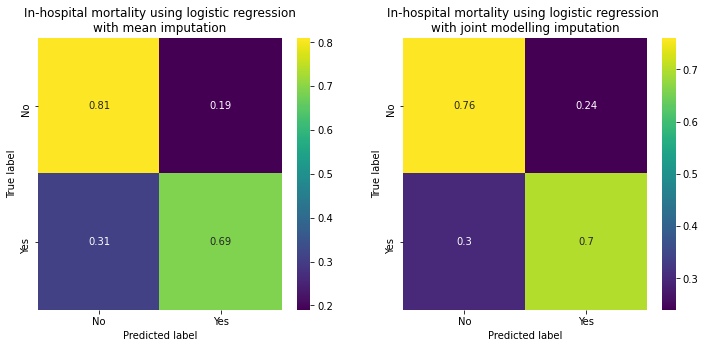

In [ ]:
# Oversampling minority results:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
cm = metrics.confusion_matrix(y_true_standard_combined, np.argmax(predictions_standard_combined, axis = 1), normalize = 'true')
df_cf = pd.DataFrame(np.round(cm, 2), index = ['No', 'Yes'], columns = ['No', 'Yes'])
sn.heatmap(df_cf, annot=True, cmap="viridis", ax = ax[0])
ax[0].set_title('In-hospital mortality using logistic regression\nwith mean imputation')
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')

cm = metrics.confusion_matrix(y_true_logreg_combined_ae, np.argmax(predictions_logreg_combined_ae, axis = 1), normalize = 'true')
df_cf = pd.DataFrame(np.round(cm, 2), index = ['No', 'Yes'], columns = ['No', 'Yes'])
sn.heatmap(df_cf, annot=True, cmap="viridis", ax = ax[1])
ax[1].set_title('In-hospital mortality using logistic regression \nwith joint modelling imputation')
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')

Text(0.5, 1.0, 'ROC curves for in-hospital mortality prediction \n (one hot encoding)')

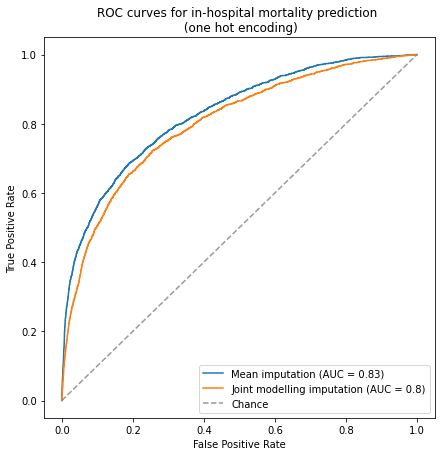

In [ ]:
# ROC AUC curve:
roc_auc_mean = metrics.roc_auc_score(y_true_standard_combined, predictions_standard_combined[:, 1])
fpr_mean, tpr_mean, threshold_mean = metrics.roc_curve(y_true_standard_combined, predictions_standard_combined[:, 1])

roc_auc_joint = metrics.roc_auc_score(y_true_logreg_combined_ae, predictions_logreg_combined_ae[:, 1])
fpr_joint, tpr_joint, threshold_joint = metrics.roc_curve(y_true_logreg_combined_ae, predictions_logreg_combined_ae[:, 1])

fig, ax = plt.subplots(figsize = (7, 7))
ax.plot(fpr_mean, tpr_mean, label = 'Mean imputation (AUC = ' + str(round(roc_auc_mean, 2)) + ')')
ax.plot(fpr_joint, tpr_joint, label = 'Joint modelling imputation (AUC = ' + str(round(roc_auc_joint, 2)) + ')')
ax.plot([0, 1], [0, 1], linestyle='--', color = 'gray', label = 'Chance', alpha=0.8)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for in-hospital mortality prediction \n (one hot encoding)')